# Advanced Uncertainty Quantification and Novelty Detection for Random Forest Model

## Essential Features of MACAU in Synthethic Moons Dataset


In this demonstration, we showcase MACAU (Model-based AleatoriC and epistemic uncertAinty qUantification) through a simple binary classification example. MACAU, as discussed in [1], offers a unique ability to model both aleatoric and epistemic uncertainties, represented separately as $\sigma$. However, expressing epistemic uncertainty accurately in out-of-distribution (OOD) scenarios poses challenges. To address this, MACAU introduces a novel concept: it quantifies _novelty_, indicating the likelihood that a sample is an outlier.

MACAU also integrates methods from [2] to elucidate the source of novelty. This explanation is presented as a breakdown of novelty probability for each feature in relation to individual samples. Consequently, it becomes feasible to pinpoint which features contribute most significantly to the overall novelty. Furthermore, MACAU incorporates the Shapley Cell Detector algorithm [2] to explain novelty in the original feature space. This enhancement enables data analysts to grasp the underlying reasons behind novelty by visualizing the contributions of features rather than relying solely on probabilities.

[1] https://aircconline.com/csit/papers/vol13/csit131920.pdf

[2] https://arxiv.org/pdf/2210.10063.pdf

##  Demonstration

Let's kick off by importing the essential libraries for this demonstration. Next up, we'll define the dataset that serves as the canvas for showcasing MACAU's key features. For this purpose, we've chosen the "moons" dataset. By default, the "moons" dataset is 2D, making both features crucial for classification. However, to illustrate how MACAU handles additional noise, we'll inject an extraneous third feature composed of Gaussian noise, to later show how it is visible, if it is, as novelty.

In [1]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import lightgbm
from macau.MACAU import MACAU

X, Y = make_moons(n_samples = 10000, noise = 0.2)
X = np.hstack([X, np.random.normal(0, 1, X.shape[0]).reshape(-1, 1)])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

Now, let's proceed by training a LightGBM binary classifier on our training dataset, as is customary. Once we've fitted our primary classifier, we'll train MACAU using the same training data. And voila! That's all it takes to get MACAU up and running.

In [3]:
lgbm_model = lightgbm.LGBMClassifier(boosting_type = 'rf',
                                     importance_type = 'gain',
                                     n_estimators = 100,
                                     max_depth = -1,
                                     colsample_bytree = 1.0,
                                     subsample_freq = 1,
                                     subsample = 0.1,
                                     reg_alpha = 0,
                                     reg_lambda = 0,
                                     verbose = -1,
                                     num_leaves = 31,
                                     min_child_samples = 20,
                                     n_jobs = 10)

lgbm_model.fit(X_train, Y_train)
macau = MACAU(lgbm_model).fit(X_train, Y_train)

In order to depict the decision, uncertainty and novelty surfaces, we make a grid 3D samples which are then predicted with MACAU. In addition, we explain the novelty contributions from novelty probability perspective and also feature SCD-perspective.

In [6]:
x_grid, y_grid = np.meshgrid(np.linspace(1.25 * X.min(axis = 0)[0], 1.25 * X.max(axis = 0)[0], 100),
                             np.linspace(1.25 * X.min(axis = 0)[1], 1.25 * X.max(axis = 0)[1], 100))
grid_xy = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
grid_xy = np.hstack([grid_xy, np.random.normal(0, 1, grid_xy.shape[0]).reshape(-1, 1)])

# predict
pred = macau.predict(grid_xy)

# feature novelty probabilities
shap_novelty_contributors, shap_conditional_novelty_contributors = macau.novelty_explanations(grid_xy, shap_values = True)

# SCD
novelty_contributors, conditional_novelty_contributors = macau.novelty_explanations(grid_xy, shap_values = False)

Now, let's plot the most essential surfaces.

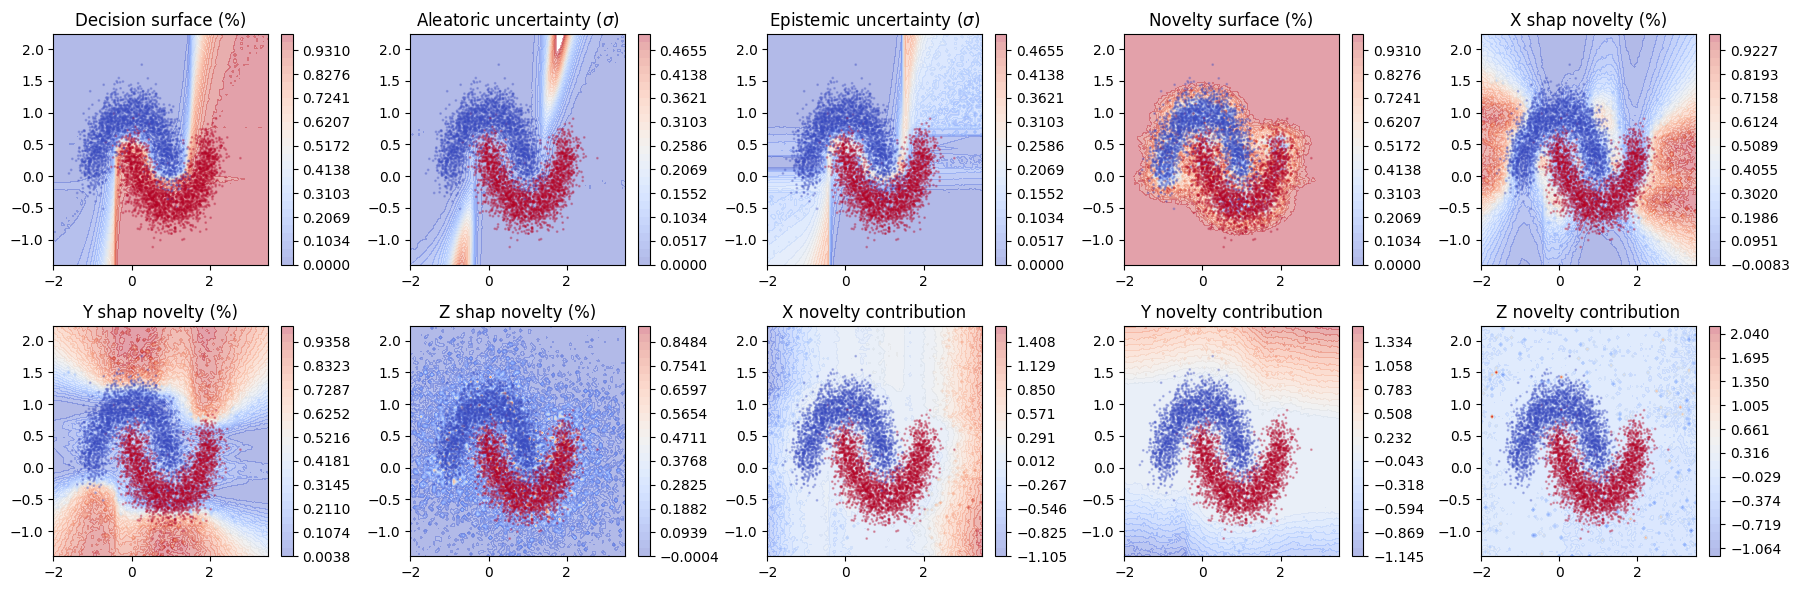

In [7]:
grid_decision_surface = pred[:, 0].reshape(x_grid.shape) # decision surface
grid_aleatoric_surface = pred[:, -3].reshape(x_grid.shape) # aleatoric uncertainty
grid_epistemic_surface = pred[:, -2].reshape(x_grid.shape) # epistemic uncertainty

grid_novelty_surface = pred[:, 2].reshape(x_grid.shape) # novelty surface

grid_shap_x_surface = shap_novelty_contributors[:, 0].reshape(x_grid.shape) # x-axis novelty surface
grid_shap_y_surface = shap_novelty_contributors[:, 1].reshape(x_grid.shape) # y-axis novelty surface
grid_shap_z_surface = shap_novelty_contributors[:, 2].reshape(x_grid.shape) # z-axis novelty surface

grid_contrib_x_surface = novelty_contributors[:, 0].reshape(x_grid.shape) # x-axis SCD surface
grid_contrib_y_surface = novelty_contributors[:, 1].reshape(x_grid.shape) # y-axis SCD surface
grid_contrib_z_surface = novelty_contributors[:, 2].reshape(x_grid.shape) # z-axis SCD surface


fig, ax = plt.subplots(figsize = (18, 6), ncols = 5, nrows = 2)
ax = ax.ravel()
ax[0].set_title('Decision surface (%)')
ax[1].set_title(r'Aleatoric uncertainty ($\sigma$)')
ax[2].set_title(r'Epistemic uncertainty ($\sigma$)')
ax[3].set_title('Novelty surface (%)')
ax[4].set_title('X shap novelty (%)')
ax[5].set_title('Y shap novelty (%)')
ax[6].set_title('Z shap novelty (%)')
ax[7].set_title('X novelty contribution')
ax[8].set_title('Y novelty contribution')
ax[9].set_title('Z novelty contribution')

for axis in ax:
    axis.set_xlim(grid_xy[:, 0].min(), grid_xy[:, 0].max())

contour = ax[0].contourf(x_grid, y_grid, grid_decision_surface, levels = np.linspace(0.0, 1.0, 30), vmin = 0.0, vmax = 1.0, alpha = 0.4, cmap = 'coolwarm')    
ax[0].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[0])

contour = ax[1].contourf(x_grid, y_grid, grid_aleatoric_surface, levels = np.linspace(0.0, 0.5, 30), vmin = 0.0, vmax = 0.5, alpha = 0.4, cmap = 'coolwarm')    
ax[1].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[1])

contour = ax[2].contourf(x_grid, y_grid, grid_epistemic_surface, levels = np.linspace(0.0, 0.5, 30), vmin = 0.0, vmax = 0.5, alpha = 0.4, cmap = 'coolwarm')    
ax[2].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[2])

contour = ax[3].contourf(x_grid, y_grid, grid_novelty_surface, levels = np.linspace(0.0, 1.0, 30), vmin = 0.0, vmax = 1.0, alpha = 0.4, cmap = 'coolwarm')    
ax[3].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[3])

contour = ax[4].contourf(x_grid, y_grid, grid_shap_x_surface, levels = np.linspace(grid_shap_x_surface.min(), grid_shap_x_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')    
ax[4].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[4])

contour = ax[5].contourf(x_grid, y_grid, grid_shap_y_surface, levels = np.linspace(grid_shap_y_surface.min(), grid_shap_y_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')    
ax[5].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[5])

contour = ax[6].contourf(x_grid, y_grid, grid_shap_z_surface, levels = np.linspace(grid_shap_z_surface.min(), grid_shap_z_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')    
ax[6].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[6])

contour = ax[7].contourf(x_grid, y_grid, grid_contrib_x_surface, levels = np.linspace(grid_contrib_x_surface.min(), grid_contrib_x_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')    
ax[7].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[7])

contour = ax[8].contourf(x_grid, y_grid, grid_contrib_y_surface, levels = np.linspace(grid_contrib_y_surface.min(), grid_contrib_y_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')    
ax[8].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[8])

contour = ax[9].contourf(x_grid, y_grid, grid_contrib_z_surface, levels = np.linspace(grid_contrib_z_surface.min(), grid_contrib_z_surface.max(), 30), alpha = 0.4, cmap = 'coolwarm')    
ax[9].scatter(X_test[:, 0], X_test[:, 1], c = Y_test, cmap = 'coolwarm', s = 1, alpha = 0.3, label = 'samples')
fig.colorbar(contour, ax = ax[9])

fig.tight_layout()

The decision surface vividly illustrates MACAU's predictions across the predicted grid. As evident, the prediction task appears straightforward, a scenario where most random forest models could predict accurately.

Aleatoric uncertainty reveals where the model acknowledges its uncertainty and to what extent. On the other hand, epistemic uncertainty highlights areas where the model lacks knowledge. In classification scenarios, epistemic uncertainty tends to peak at decision boundaries. However, in MACAU's modelling, this type of uncertainty fails to capture true _unknown_ out-of-distribution cases, hence the concept of _novelty_.

In MACAU, novelty is quantified using leaf-wise Mahalanobis distance, typically represented as Z-scores. To enhance interpretability, MACAU transforms Z-scores into probabilities by leveraging the chi-square distribution of squared Mahalanobis distance. Consequently, the novelty surface expresses the likelihood that a sample is an outlier. As observed in this case, the novelty surface adeptly identifies regions of space lacking training data, thus marking them as outliers. Consequently, it's advisable to refrain from predicting samples with high novelty, as the model's behavior in those regions isn't guaranteed.

Breaking down novelty, we introduce _shap novelty_. X shap novelty indicates the contribution of the x-axis to the overall novelty, with the total novelty being the sum of contributions from each axis. As depicted, venturing away from regions with samples amplifies the x shap novelty, a trend mirrored in y shap novelty, each corresponding to its respective axis. However, z shap novelty remains independent of the x- or y-axis, as depicted.

X/Y/Z novelty contributions stem from leaf-wise Shapley Cell Detector (SCD) analysis. These values, expressed in the original scale, highlight how much a sample's feature values deviate — positively indicating values that are too high and negatively indicating the opposite. This representation provides data analysts with a clearer understanding of why a particular sample is deemed novel.

## Conclusions

MACAU offers sophisticated capabilities for uncertainty modeling, with _novelty_ modeling serving to complement epistemic uncertainty by addressing out-of-distribution (OOD) cases. As demonstrated earlier, _novelty_ can also be broken down and elucidated on a feature-wise basis, empowering data analysts to gain deeper insights into why specific samples appear to be outliers within the prediction context.